# Predicting False information about Crime using Supervised Learning
- Under the guidance of : Dr. Professor Barber
- Submitted by : Anusha Ayyagari & Harikrishna Bhumani
- [Github Repository](https://github.com/haribhumani/capstone_project)  
- [Project Website](https://sites.google.com/umbc.edu/fake-news-detection/home)

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import the dependencies

import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import nltk
import re
import string
from textblob import TextBlob
import sys
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn import naive_bayes
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import chi2_contingency 

import statsmodels.api as sm
from statsmodels.formula.api import ols

## Web scrapping 

We are scraping the data from the sections 'crime','guns' and 'marijuana'   as most of the statemets are made in the context of Crime. We are obtaining this data from the website 'Poltifact' where the statements are analysed and fact checked and labeled by unbaised journalists.

we are using Beautiful Soup library for scrapping the desired fields from the website.

Please find the link to the website below:

https://www.politifact.com/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scarp_pages = 50

upperframe = []  
error_pages = []
categories = ['&category=crime','&category=guns','&category=marijuana']

# retrive the news content from the given url
def get_content(url):

    response = requests.get(url)
    content = BeautifulSoup(response.text,'html.parser')
    result = None
    try:
        result = content.find("article",attrs={'class':'m-textblock'}).text.replace('\n','').strip()
    except:
        error_pages.append(url)
    return result

# iterate on each category
for category in categories: 
    
    # no. of pages to scrape
    for page in range(1,scarp_pages+1):
        website = 'https://www.politifact.com/factchecks/list/?page='+str(page)+category
        page = requests.get(website)                             
        soup = BeautifulSoup(page.text,'html.parser')
        frame = []
        articles = soup.find_all('li',attrs={'class':'o-listicle__item'})
        filename = '/content/drive/Shareddrives/NLP_project_materials/news_content.csv'
        file = open(filename,"w", encoding = 'utf-8')
        headers = "Statement, Link, Date, Source, Context, MsgContent, Label\n"
        file.write(headers)

        # retriev the meta data for each news items collected in the current page
        for article in articles:
            statement = article.find("div",attrs={'class':'m-statement__quote'}).text.strip()
            link = "https://www.politifact.com"
            link += article.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
            date = article.find('div',attrs={'class':'m-statement__body'}).find('footer').text[:-1].strip()
            source = article.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
            context = article.find('div', attrs={'class':'m-statement__desc'}).text.strip()
            msg_content = get_content(link)
            # None cannot be appended to str
            msg_content = "" if msg_content == None else msg_content

            label = article.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
            
            frame.append((statement, link, date, source, context, msg_content, label))
            file.write(statement.replace(",","^")+","+link+","+date.replace(",","^")+","+source.replace(",","^")+","+","+context+","+msg_content+","+label.replace(",","^")+"\n")
        
        upperframe.extend(frame)

file.close()

In [ ]:
data = pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','context','MsgContent','Label'])
data.head()

,Statement,Link,Date,Source,context,MsgContent,Label
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,"By Warren Fiske • December 2, 2022",Cliff Hayes,"stated on November 23, 2022 in a TV interview.:",The day after six people died in a mass shooti...,mostly-true
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,"By Andy Nguyen • November 22, 2022",Tweets,"stated on November 20, 2022 in a tweet:",News about the Nov. 19 mass shooting that kill...,pants-fire
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,"By Warren Fiske • November 4, 2022",Yesli Vega,"stated on October 20, 2022 in an interview.:",Republican Yesli Vega was recently asked to el...,half-true
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,"By Madeline Heim • November 4, 2022",Tim Michels,"stated on October 24, 2022 in News conference:","With crime a central focus of the campaign, Re...",false
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,"By Sydney Carruth • November 2, 2022",Kris Mayes,"stated on September 28, 2022 in a debate:",In the Sept. 28 attorney general debate hosted...,barely-true


The below are the fields that we have extracted for our analysis.

In [ ]:
data['Label'].value_counts()

false          499
half-true      347
mostly-true    335
barely-true    311
true           224
pants-fire     217
full-flop        2
no-flip          1
half-flip        1
Name: Label, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Statement   1937 non-null   object
 1   Link        1937 non-null   object
 2   Date        1937 non-null   object
 3   Source      1937 non-null   object
 4   context     1937 non-null   object
 5   MsgContent  1937 non-null   object
 6   Label       1937 non-null   object
dtypes: object(7)
memory usage: 106.1+ KB


In [ ]:
data['Statement'] = data['Statement'].str.replace("\"","")
data

,Statement,Link,Date,Source,context,MsgContent,Label
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,"By Warren Fiske • December 2, 2022",Cliff Hayes,"stated on November 23, 2022 in a TV interview.:",The day after six people died in a mass shooti...,mostly-true
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,"By Andy Nguyen • November 22, 2022",Tweets,"stated on November 20, 2022 in a tweet:",News about the Nov. 19 mass shooting that kill...,pants-fire
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,"By Warren Fiske • November 4, 2022",Yesli Vega,"stated on October 20, 2022 in an interview.:",Republican Yesli Vega was recently asked to el...,half-true
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,"By Madeline Heim • November 4, 2022",Tim Michels,"stated on October 24, 2022 in News conference:","With crime a central focus of the campaign, Re...",false
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,"By Sydney Carruth • November 2, 2022",Kris Mayes,"stated on September 28, 2022 in a debate:",In the Sept. 28 attorney general debate hosted...,barely-true
...,...,...,...,...,...,...,...
1932,Transporting drugs is the price of admission f...,https://www.politifact.com/factchecks/2010/jul...,"By C. Eugene Emery Jr. • July 20, 2010",John Loughlin,"stated on July 9, 2010 in a comment on The Hel...","John Loughlin, a Republican running for Congre...",pants-fire
1933,The majority of the people that are coming to ...,https://www.politifact.com/factchecks/2010/jun...,"By Louis Jacobson • June 30, 2010",Jan Brewer,"stated on June 25, 2010 in a television interv...",Arizona Republican Gov. Jan Brewer created a f...,false
1934,More people are driving under the influence of...,https://www.politifact.com/factchecks/2010/apr...,"By Louis Jacobson • April 5, 2010",Gil Kerlikowske,"stated on March 31, 2010 in an interview on C-...",Much has been made of the United States' succe...,half-true
1935,Only 15 percent of drug users are African-Amer...,https://www.politifact.com/factchecks/2009/jul...,"By Louis Jacobson • July 28, 2009",Arianna Huffington,"stated on July 26, 2009 in This Week with Geor...",In another example of how the arrest of Africa...,half-true



# **Data Cleaning:**

In this section we are cleaning the data that we have scarped so that we can use the data for further analysis.

These are the below steps that we are taking for the data.

•	The column 'Date' is split into columns fact_checker and the date_verified. Where fact checker provides information about the person who has verified the data and assigned the respective label, and the date represents the date when fact checking was completed.

•	The column ‘Context' is split into columns date_stated and 'stated platform' column which provides information about date when the statement was made, and the 'stated_platform' provides information about the platform/media source/interview source where the person/organization/source that made the statement.

•	The columns 'Date' and 'context' are dropped as they are no longer needed

•	Data cleaning is performed in columns 'fact_checker' and 'date_stated' by removing unnecessary information and make the columns more readable.

•	The function ‘cleaner’ is written so that the alphanumeric characters in the text are removed as well as NLTK library is used to tokenize the text, convert the text to lowercase and remove any words that are not defined in NLTK corpus word module

•	The function is applied to columns ‘MsgContent’ and ‘Stated_source’

•	The rows with labels ‘full-flop’,’ no-flip’ and ‘half-flip’ are dropped as they provide no insight.

•	The columns ‘date_stated’ and ‘date’ are converted to datetime datatype and miscellaneous data cleaning is performed.


•	The ‘Stated_source’ column is modified to reflect generalized sources.







In [ ]:
'''
• The column Date is split into columns fact_checker and the date. Where fact checker provides information about the person who has verified the data and assigned the respective label, and the date represents the date when fact checking was completed.

• The column ‘Context' is split into columns date_stated and 'stated source' column which provides information about date when the statement was made, and the 'stated source' provides information about the platform/media source/interview source where the person/organization/source that made the statement.
'''

pd.options.mode.chained_assignment = None
data[['fact_checker','date_verified']] = data['Date'].str.split('•', n=1,expand=True)
data[['date_stated','stated_platform']] = data['context'].str.split('in', n=1,expand=True)

In [ ]:
data

,Statement,Link,Date,Source,context,MsgContent,Label,fact_checker,date_verified,date_stated,stated_platform
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,"By Warren Fiske • December 2, 2022",Cliff Hayes,"stated on November 23, 2022 in a TV interview.:",The day after six people died in a mass shooti...,mostly-true,By Warren Fiske,"December 2, 2022","stated on November 23, 2022",a TV interview.:
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,"By Andy Nguyen • November 22, 2022",Tweets,"stated on November 20, 2022 in a tweet:",News about the Nov. 19 mass shooting that kill...,pants-fire,By Andy Nguyen,"November 22, 2022","stated on November 20, 2022",a tweet:
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,"By Warren Fiske • November 4, 2022",Yesli Vega,"stated on October 20, 2022 in an interview.:",Republican Yesli Vega was recently asked to el...,half-true,By Warren Fiske,"November 4, 2022","stated on October 20, 2022",an interview.:
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,"By Madeline Heim • November 4, 2022",Tim Michels,"stated on October 24, 2022 in News conference:","With crime a central focus of the campaign, Re...",false,By Madeline Heim,"November 4, 2022","stated on October 24, 2022",News conference:
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,"By Sydney Carruth • November 2, 2022",Kris Mayes,"stated on September 28, 2022 in a debate:",In the Sept. 28 attorney general debate hosted...,barely-true,By Sydney Carruth,"November 2, 2022","stated on September 28, 2022",a debate:
...,...,...,...,...,...,...,...,...,...,...,...
1932,Transporting drugs is the price of admission f...,https://www.politifact.com/factchecks/2010/jul...,"By C. Eugene Emery Jr. • July 20, 2010",John Loughlin,"stated on July 9, 2010 in a comment on The Hel...","John Loughlin, a Republican running for Congre...",pants-fire,By C. Eugene Emery Jr.,"July 20, 2010","stated on July 9, 2010",a comment on The Helen Glover Show:
1933,The majority of the people that are coming to ...,https://www.politifact.com/factchecks/2010/jun...,"By Louis Jacobson • June 30, 2010",Jan Brewer,"stated on June 25, 2010 in a television interv...",Arizona Republican Gov. Jan Brewer created a f...,false,By Louis Jacobson,"June 30, 2010","stated on June 25, 2010",a television interview:
1934,More people are driving under the influence of...,https://www.politifact.com/factchecks/2010/apr...,"By Louis Jacobson • April 5, 2010",Gil Kerlikowske,"stated on March 31, 2010 in an interview on C-...",Much has been made of the United States' succe...,half-true,By Louis Jacobson,"April 5, 2010","stated on March 31, 2010",an interview on C-SPAN's Washington Journal:
1935,Only 15 percent of drug users are African-Amer...,https://www.politifact.com/factchecks/2009/jul...,"By Louis Jacobson • July 28, 2009",Arianna Huffington,"stated on July 26, 2009 in This Week with Geor...",In another example of how the arrest of Africa...,half-true,By Louis Jacobson,"July 28, 2009","stated on July 26, 2009",This Week with George Stephanopoulos:


In [ ]:
#cleaning the data to remove unwanted words from the columns fact checker and date stated
data['fact_checker']=data['fact_checker'].str.replace('By ','')
data['date_stated']=data['date_stated'].str.replace('stated on ','')

In [ ]:
data

,Statement,Link,Date,Source,context,MsgContent,Label,fact_checker,date_verified,date_stated,stated_platform
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,"By Warren Fiske • December 2, 2022",Cliff Hayes,"stated on November 23, 2022 in a TV interview.:",The day after six people died in a mass shooti...,mostly-true,Warren Fiske,"December 2, 2022","November 23, 2022",a TV interview.:
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,"By Andy Nguyen • November 22, 2022",Tweets,"stated on November 20, 2022 in a tweet:",News about the Nov. 19 mass shooting that kill...,pants-fire,Andy Nguyen,"November 22, 2022","November 20, 2022",a tweet:
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,"By Warren Fiske • November 4, 2022",Yesli Vega,"stated on October 20, 2022 in an interview.:",Republican Yesli Vega was recently asked to el...,half-true,Warren Fiske,"November 4, 2022","October 20, 2022",an interview.:
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,"By Madeline Heim • November 4, 2022",Tim Michels,"stated on October 24, 2022 in News conference:","With crime a central focus of the campaign, Re...",false,Madeline Heim,"November 4, 2022","October 24, 2022",News conference:
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,"By Sydney Carruth • November 2, 2022",Kris Mayes,"stated on September 28, 2022 in a debate:",In the Sept. 28 attorney general debate hosted...,barely-true,Sydney Carruth,"November 2, 2022","September 28, 2022",a debate:
...,...,...,...,...,...,...,...,...,...,...,...
1932,Transporting drugs is the price of admission f...,https://www.politifact.com/factchecks/2010/jul...,"By C. Eugene Emery Jr. • July 20, 2010",John Loughlin,"stated on July 9, 2010 in a comment on The Hel...","John Loughlin, a Republican running for Congre...",pants-fire,C. Eugene Emery Jr.,"July 20, 2010","July 9, 2010",a comment on The Helen Glover Show:
1933,The majority of the people that are coming to ...,https://www.politifact.com/factchecks/2010/jun...,"By Louis Jacobson • June 30, 2010",Jan Brewer,"stated on June 25, 2010 in a television interv...",Arizona Republican Gov. Jan Brewer created a f...,false,Louis Jacobson,"June 30, 2010","June 25, 2010",a television interview:
1934,More people are driving under the influence of...,https://www.politifact.com/factchecks/2010/apr...,"By Louis Jacobson • April 5, 2010",Gil Kerlikowske,"stated on March 31, 2010 in an interview on C-...",Much has been made of the United States' succe...,half-true,Louis Jacobson,"April 5, 2010","March 31, 2010",an interview on C-SPAN's Washington Journal:
1935,Only 15 percent of drug users are African-Amer...,https://www.politifact.com/factchecks/2009/jul...,"By Louis Jacobson • July 28, 2009",Arianna Huffington,"stated on July 26, 2009 in This Week with Geor...",In another example of how the arrest of Africa...,half-true,Louis Jacobson,"July 28, 2009","July 26, 2009",This Week with George Stephanopoulos:


In [ ]:
# cleaning the data so that all alpha-numeric characters are removed an any words that are not defined in nltk corpus
pd.options.mode.chained_assignment = None
nltk.download('words')
words = set(nltk.corpus.words.words())

def cleaner(text):
    text = str(text)
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    #text=re.sub('[\W_]+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = " ".join(text.split())
    text = text.replace("'", "")
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha())
    return text
#data['Statement'] = data['Statement'].map(lambda x: cleaner(x))
data['MsgContent'] = data['MsgContent'].map(lambda x: cleaner(x))
#removing 'true' and 'false' words from the dataset to remove bias from the dataset 
data['MsgContent']=data['MsgContent'].str.lower()
data['MsgContent'] = data['MsgContent'].str.replace('true',' ')
data['MsgContent'] = data['MsgContent'].str.replace('false',' ')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#finding out all the unique labels 
data['Label'].unique()

array(['mostly-true', 'pants-fire', 'half-true', 'false', 'barely-true',
       'true', 'full-flop', 'no-flip', 'half-flip'], dtype=object)

In [ ]:
# The columns 'Date' and 'context' are dropped as they are no longer needed
data.drop(['Date','context'],axis=1, inplace=True)

checking for all the unique labels and deleting the labels that are not significant(i.e the number of these  labels are pretty low in the dataset)

In [ ]:
data['Label'].value_counts()

false          499
half-true      347
mostly-true    335
barely-true    311
true           224
pants-fire     217
full-flop        2
no-flip          1
half-flip        1
Name: Label, dtype: int64

In [ ]:
#droping rows with the label as 'full-flop','no-flip' and 'half-flip'
inddrop = data[ (data['Label'] == 'full-flop') | (data['Label'] == 'no-flip') |  (data['Label'] == 'half-flip')].index
data.drop(inddrop , inplace=True)
data.head(15)

,Statement,Link,Source,MsgContent,Label,fact_checker,date_verified,date_stated,stated_platform
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,Cliff Hayes,the day after six people in a mass shooting at...,mostly-true,Warren Fiske,"December 2, 2022","November 23, 2022",a TV interview.:
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,Tweets,news about the . mass shooting that five peopl...,pants-fire,Andy Nguyen,"November 22, 2022","November 20, 2022",a tweet:
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,Yesli Vega,republican was recently to elaborate on a cont...,half-true,Warren Fiske,"November 4, 2022","October 20, 2022",an interview.:
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,Tim Michels,"with crime a central focus of the campaign , r...",false,Madeline Heim,"November 4, 2022","October 24, 2022",News conference:
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,Kris Mayes,"in the sept . attorney general debate by , dem...",barely-true,Sydney Carruth,"November 2, 2022","September 28, 2022",a debate:
5,"At the Pelosi house, “the glass it seems was b...",https://www.politifact.com/factchecks/2022/nov...,Donald Trump,former president trump elevated a conspiracy t...,pants-fire,Gabrielle Settles,"November 2, 2022","November 1, 2022",a podcast interview:
6,“One in six local election officials have rece...,https://www.politifact.com/factchecks/2022/nov...,Amy Klobuchar,the violent attack . on the husband of house s...,mostly-true,Amy Sherman,"November 1, 2022","October 30, 2022",an interview on Meet the Press:
7,Police dispatch audio from Paul Pelosi’s attac...,https://www.politifact.com/factchecks/2022/nov...,Instagram posts,have the emergency dispatcher who fielded ’ s ...,pants-fire,Ciara O'Rourke,"November 1, 2022","November 29, 2022",an Instagram post:
8,Security cameras at Nancy Pelosi’s San Francis...,https://www.politifact.com/factchecks/2022/nov...,Viral image,amid misinformation about the . assault of hou...,pants-fire,Ciara O'Rourke,"November 1, 2022","October 30, 2022",an Instagram post:
9,The Pelosis “are refusing to turn over surveil...,https://www.politifact.com/factchecks/2022/oct...,Viral image,been with the of house speaker nancy and an as...,false,Ciara O'Rourke,"October 31, 2022","October 29, 2022",an Instagram post:


In [ ]:
# The columns ‘date_stated’ and ‘date’ are converted to datetime datatype and miscellaneous data cleaning is performed
data['date_verified'] = pd.to_datetime(data['date_verified'])
data['date_stated'] = data['date_stated'].str.replace(':','')
data['stated_platform'] = data['stated_platform'].str.replace(':','')
data['date_stated'] = pd.to_datetime(data['date_stated'])
data['stated_platform'] = data['stated_platform'].astype(str)

In [ ]:
#The ‘Stated_source’ column is modified to reflect generalized sources

def source_update(text):
    
    text=text.lower()
    if 'debate' in text:
        text = 'debate'
    elif any([pltform for pltform in ('interview','on','platform','comment','aftermath','reporter','reporter','report') if pltform in text]):
        text = 'interview'
    elif 'speech' in text:
        text = 'speech'
    elif 'ad' in text or 'billboard' in text:
        text = 'ad'
    elif 'ad' in text:
        text = 'ad'
    elif 'news' in text or 'segment' in text or 'press' in text or 'opinion' in text or 'column' in text or 'article' in text or 'commentary' in text or 'editorial' in text or 'times' in text:
        text = 'press'
    elif 'episode' in text or 'media' in text or 'photo'in text or 'sketch' in text or 'video' in text or 'forum' in text or 'show' in text or 'series' in text or 'talk' in text or 'this week with' in text or 'flier' in text or 'briefing' in text or 'brief' in text or 'live'in text:
        text = 'media'
    elif 'post' in text or 'social media' in text or 'blast' in text or 'web' in text or 'image' in text or 'posting' in text or 'mail' in  text or 'mailer' in text or 'Instagram' in text or 'twitter' in text or 'tweet' in text or 'facebook' in text:
        text = 'social media'
    elif 'hearing' in text:
        text = 'hearing'
    elif 'testimony' in text:
        text = 'testimony'
    elif 'campaign' in text or 'rally' in text:
        text = 'campaign'
    elif 'statement ' in text or 'resolution' in text:
        text = 'statement'
    elif 'convention' in text or 'meeting' in text or 'conference' in text or 'town hall' in text or 'event' in text or 'discussion' in text or 'committee' in text or 'discussion' in text:
        text = 'meeting'
    elif 'letter' in text:
        text = 'letter'
    elif 'senate' in text or 'white house' in text:
        text = 'political office'
    elif 'message'in text or 'call' in text or 'graphic' in text or 'appearance' in text or 'presentation' in text or 'petition' in text:
        text = 'message'
    else :
        text = 'others'
    return text

data['stated_platform'] = data['stated_platform'].map(lambda x: cleaner(x))
data['stated_platform'] = data['stated_platform'].map(lambda text: source_update(text))

In [ ]:
data

,Statement,Link,Source,MsgContent,Label,fact_checker,date_verified,date_stated,stated_platform
0,"“When you compare us to the European Union, we...",https://www.politifact.com/factchecks/2022/dec...,Cliff Hayes,the day after six people in a mass shooting at...,mostly-true,Warren Fiske,2022-12-02,2022-11-23,interview
1,The Club Q shooting was a “false flag.”,https://www.politifact.com/factchecks/2022/nov...,Tweets,news about the . mass shooting that five peopl...,pants-fire,Andy Nguyen,2022-11-22,2022-11-20,social media
2,They were “never my comments” that a woman can...,https://www.politifact.com/factchecks/2022/nov...,Yesli Vega,republican was recently to elaborate on a cont...,half-true,Warren Fiske,2022-11-04,2022-10-20,interview
3,"Tony Evers “wants to let out between 9,000 and...",https://www.politifact.com/factchecks/2022/nov...,Tim Michels,"with crime a central focus of the campaign , r...",false,Madeline Heim,2022-11-04,2022-10-24,interview
4,“We have seen over the last 10 years ... under...,https://www.politifact.com/factchecks/2022/nov...,Kris Mayes,"in the sept . attorney general debate by , dem...",barely-true,Sydney Carruth,2022-11-02,2022-09-28,debate
...,...,...,...,...,...,...,...,...,...
1932,Transporting drugs is the price of admission f...,https://www.politifact.com/factchecks/2010/jul...,John Loughlin,", a republican running for congress in the st ...",pants-fire,C. Eugene Emery Jr.,2010-07-20,2010-07-09,interview
1933,The majority of the people that are coming to ...,https://www.politifact.com/factchecks/2010/jun...,Jan Brewer,republican . brewer a frenzy in when she a law...,false,Louis Jacobson,2010-06-30,2010-06-25,interview
1934,More people are driving under the influence of...,https://www.politifact.com/factchecks/2010/apr...,Gil Kerlikowske,much been made of the united success in reduci...,half-true,Louis Jacobson,2010-04-05,2010-03-31,interview
1935,Only 15 percent of drug users are African-Amer...,https://www.politifact.com/factchecks/2009/jul...,Arianna Huffington,in another example of how the arrest of - scho...,half-true,Louis Jacobson,2009-07-28,2009-07-26,media


In [ ]:
#just to make sure that there are no null values in the data set
data.isnull().sum()

Statement          0
Link               0
Source             0
MsgContent         0
Label              0
fact_checker       0
date_verified      0
date_stated        0
stated_platform    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1933 entries, 0 to 1936
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Statement        1933 non-null   object        
 1   Link             1933 non-null   object        
 2   Source           1933 non-null   object        
 3   MsgContent       1933 non-null   object        
 4   Label            1933 non-null   object        
 5   fact_checker     1933 non-null   object        
 6   date_verified    1933 non-null   datetime64[ns]
 7   date_stated      1933 non-null   datetime64[ns]
 8   stated_platform  1933 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 151.0+ KB


# **Exploratory Data Analysis:**



In this section we are modifying the data to derive insights from the data.


 Create a column named days_difference that holds the value of the time required to fact check the data from the day that the statement was made.

•	Use VADER Library to get the sentiment of the ‘MsgContent’ for sentiment analysis.

•	Grouping the labels ‘barely-true’, ’pants-fire’ and 'false’ as ‘false’ as it can be inferred that the information associated with these labels is false and the labels ‘true’, ’mostly true’ and ‘half-true’ as true as the information associated with these labels is true or have some factual foundation.

•	Creating a new data frame 'sentiment_data' to check the distribution of each sentiment per label.

•	Visualizing the distribution of different sentiments for each label.

•	Creating a new data frame 'time_series_data' to with the columns 'Label','sentiment','date_verified','days_difference'.

•	Extracting year from the time_series_data and creating a new column 'year'.

•	Visualization of distribution of misinformation throughout the years.

•	Visualization of distribution of true information throughout the years.

•	Visualizing the distribution of labels in the dataset.

•	Visualizing the top 10 sources (owners of the post) of data.

•	Visualizing the top 10 sources (owners of the post) who posted true information.

•	Visualizing the top 10 sources (owners of the post) who posted misinformation.

•	Visualizing the top 10 platforms of data.

•	Visualizing the top 10 platforms for misinformation.

•	Visualizing the top 10 platforms for true information.

•	Visualizing the top 10 factcheckers


In [ ]:
#creating a new column to get information about the time required to fact check the data.
data['days_difference'] = (data['date_verified'] - data['date_stated']).dt.days

In [ ]:
#using VADER library to get the sentiment behind the posts
nltk.download('vader_lexicon')

#for index, row in data['Statement'].iteritems():
for index, row in data['MsgContent'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  comp = score['compound']
  if comp < 0:
    data.loc[index, 'sentiment'] = 'negative'
  elif comp == 0:
    data.loc[index, 'sentiment'] = 'neutral'
  else:
    data.loc[index, 'sentiment'] = 'positive'
  data.loc[index, 'compound'] = comp

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#we are converting the lables  from multiple lables to two labels true or false
def label_conversion(lab):
  if lab=='barely-true' or lab=='pants-fire' or lab=='false':
    lab=0
  elif lab=='mostly-true' or lab=='true' or lab=='half-true':
    lab=1
  return lab


data['Label'] = data['Label'].apply(label_conversion)
data['Label'].unique()

array([1, 0])

In [ ]:
#creatring a new dataframe to check the distribution  of each label and setiment
sentiment_data=pd.DataFrame(data[['Label','sentiment']].groupby(['Label','sentiment']).Label.count().unstack().reset_index())

In [ ]:
sentiment_data

sentiment,Label,negative,neutral,positive
0,0,876,3,148
1,1,747,4,155


Text(0, 0.5, 'Sentiment Count')

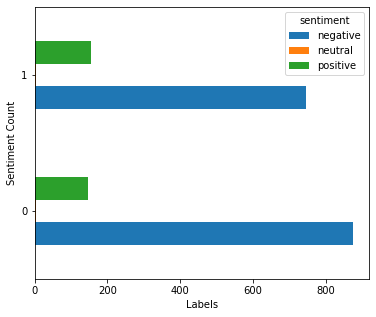

In [ ]:
#visualizing the distribution  of different sentiments for each label
sentiment_data[['negative','neutral','positive']].plot(kind='barh',figsize=(6,5))

plt.xlabel('Labels')
plt.ylabel('Sentiment Count')

In [ ]:
#creating a new dataframe to visualize the distribution  of the labels for each year
time_series_data=data[['Label','sentiment','date_verified','days_difference']]

Text(0.5, 1.0, 'distribution of amount of misinformation through the years')

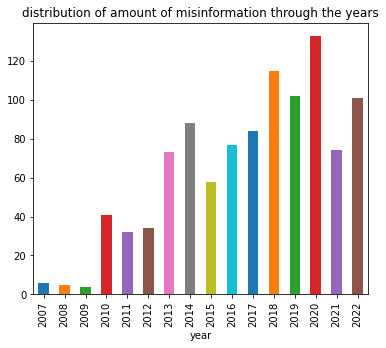

In [ ]:
colors=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9']
#extracting year from the new time series dataset to check distribution of misinformation over the years
time_series_data['year'] = pd.DatetimeIndex(time_series_data['date_verified']).year
fake_growth=time_series_data[['year','Label']].loc[(time_series_data['Label']==0)]

#Visualization of distribution  of misinformation throughout the years 
fake_growth.sort_values(['year'],ascending=True).groupby('year')['Label'].count().plot(kind='bar',figsize=(6,5),color=colors)
plt.title('distribution of amount of misinformation through the years')
#fake_growth['year'].value_counts().plot(kind='bar',figsize=(10,10),color=colors)

Text(0.5, 1.0, 'distribution of amount of true information through the years')

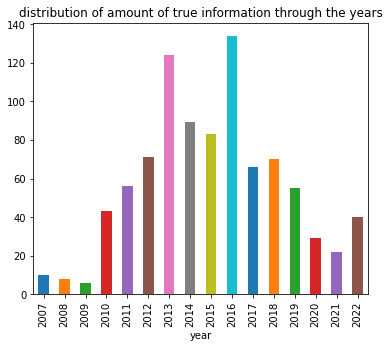

In [ ]:
#Visualization of distribution  of true information throughout the years

true_growth=time_series_data[['year','Label']].loc[(time_series_data['Label']==1)]

true_growth.sort_values(['year'],ascending=True).groupby('year')['Label'].count().plot(kind='bar',figsize=(6,5),color=colors)
plt.title('distribution of amount of true information through the years')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1933 entries, 0 to 1936
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Statement        1933 non-null   object        
 1   Link             1933 non-null   object        
 2   Source           1933 non-null   object        
 3   MsgContent       1933 non-null   object        
 4   Label            1933 non-null   int64         
 5   fact_checker     1933 non-null   object        
 6   date_verified    1933 non-null   datetime64[ns]
 7   date_stated      1933 non-null   datetime64[ns]
 8   stated_platform  1933 non-null   object        
 9   days_difference  1933 non-null   int64         
 10  sentiment        1933 non-null   object        
 11  compound         1933 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 260.9+ KB


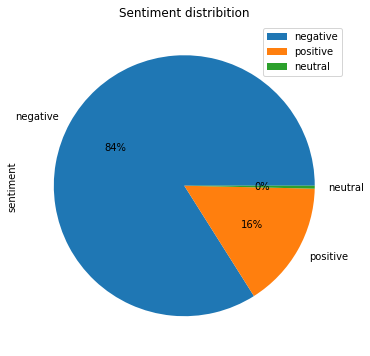

In [ ]:
#visualizing the distribution  of sentiment over the dataset
data['sentiment'].value_counts().plot(kind="pie",autopct="%1.0f%%",figsize=(10,6))
plt.title('Sentiment distribition')
plt.legend()

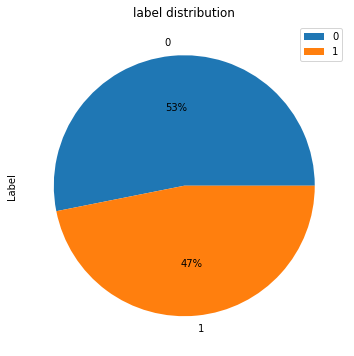

In [ ]:
#visualizing the distribution of lables in the dataset
data['Label'].value_counts().plot(kind="pie",autopct="%1.0f%%",figsize=(10,6))
plt.title('label distribution')
plt.legend()

Text(0.5, 1.0, 'Top 10 sources (people/platforms who posted the statements)')

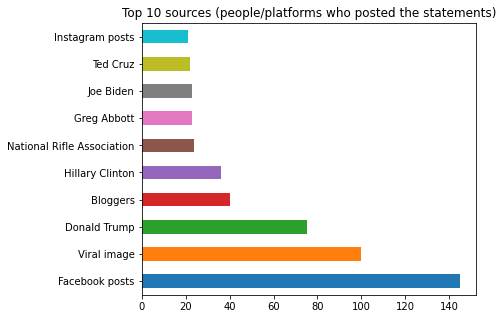

In [ ]:
#visualizing the top 10 souces(owners of the post) of data 
data['Source'].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 sources (people/platforms who posted the statements)')

Text(0, 0.5, 'Source')

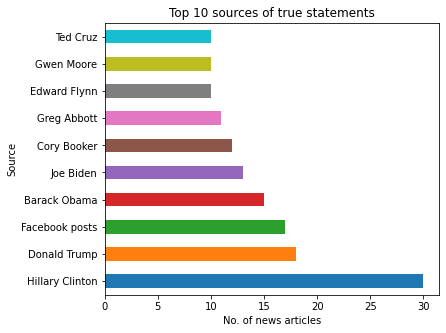

In [ ]:
#visualizing the top 10 souces(owners of the post) who posted true information 
colors=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9']

data['Source'].loc[data['Label']==1].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 sources of true statements')
plt.xlabel('No. of news articles')
plt.ylabel('Source')

Text(0, 0.5, 'Source')

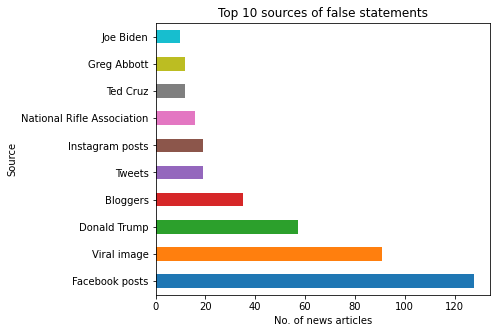

In [ ]:
#visualizing the top 10 souces(owners of the post) who posted  misinformation 
data['Source'].loc[data['Label']==0].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 sources of false statements')
plt.xlabel('No. of news articles')
plt.ylabel('Source')

Text(0.5, 1.0, 'Top 10 platforms of the dataset')

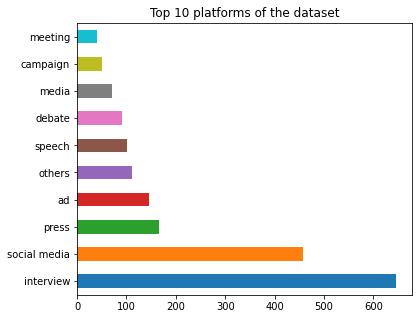

In [ ]:
#visualizing the top 10 platforms of data 
data['stated_platform'].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 platforms of the dataset')

Text(0, 0.5, 'Platform')

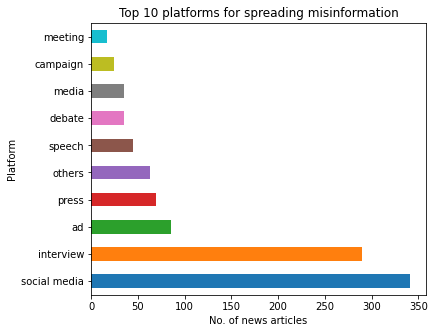

In [ ]:
#visualizing the top 10 platforms for misinformation 
data['stated_platform'].loc[data['Label']==0].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 platforms for spreading misinformation')
plt.xlabel('No. of news articles')
plt.ylabel('Platform')

Text(0, 0.5, 'Platform')

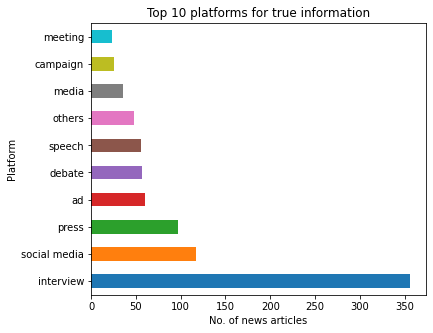

In [ ]:
#visualizing the top 10 platforms for true information 
data['stated_platform'].loc[data['Label']==1].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 platforms for true information')
plt.xlabel('No. of news articles')
plt.ylabel('Platform')

Text(0, 0.5, 'Person')

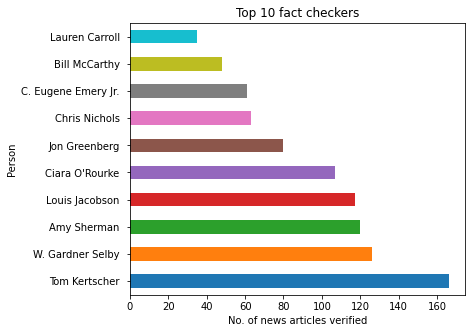

In [ ]:
#visualizing the top 10 factcheckers
data['fact_checker'].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(6,5),color=colors)
plt.title('Top 10 fact checkers')
plt.xlabel('No. of news articles verified')
plt.ylabel('Person')

# **Statistical Analysis:**

In this section we are trying to find insights from the data by making few assumptions about the data and using the statistical tests to check if our assumptions are correct.

1.	We are trying to find if the correlation of different independent numeric variables and the label.

2.	We are trying to find the dependency between source (owners of information) and the Label using hypothesis testing:
H0(Null Hypothesis): The Label and Source are independent.
H1(Alternate Hypothesis): The Label and Source are dependent.
Result: We reject the null hypothesis as the p value is less than 0.05

3.	We are trying to find the dependency between platform where the information was posted and the Label using hypothesis testing:
H0(Null Hypothesis): The Label and platform where the information was posted are independent.
H1(Alternate Hypothesis): The Label and platform where the information was posted are dependent.
Result: We reject the null hypothesis as the p value is less than 0.05


4.	We are trying to find the dependency between the negative sentiment and the Label using hypothesis testing:
H0(Null Hypothesis): The Label and negative sentiment are independent.
H1(Alternate Hypothesis): The Label and negative sentiment are dependent.
Result: We accept the null hypothesis as the p value is greater than 0.05.

5.	We are trying to visualize the most common words associated with the false label.

6.	We are trying to visualize the most common words associated with true label.

7.	We are trying to find the average time (in days) to check if the information is true.

8.	We are trying to find the average time (in days) to check if the information is false.


In [ ]:
#to check the correlaion of independent parameters and the dependent variaable
data.corr()['Label']

Label              1.000000
days_difference   -0.007665
compound           0.043041
Name: Label, dtype: float64

In [ ]:
#H0: The Label and Source are independent
#H1 : the Label anb Source are dependent

source_df=pd.DataFrame()
source_df['Label'] = data['Label']
source_df['Source'] = data['Source']

source_df = pd.crosstab( source_df["Label"],source_df['Source'])
stat_senti, p_sent, dof_sent, expected_senti = chi2_contingency(source_df) 

alpha = 0.05
if p_sent <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 
print('the p value is: ',p_sent)

Dependent (reject H0)
the p value is:  9.504909809381835e-19


In [ ]:
#H0: The Label and platform where the information was posted are independent
#H1 : the Label and platform where the information was posted are dependent

platform_df=pd.DataFrame()
platform_df["Label"]=data['Label']
platform_df['stated_platform']=data['stated_platform']

platform_df.dropna(inplace=True)

data_crosstab = pd.crosstab( platform_df["Label"],platform_df['stated_platform'])
stat, p, dof, expected = chi2_contingency(data_crosstab) 

alpha = 0.05
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 
print('the p value is: ',p)

Dependent (reject H0)
the p value is:  6.5862381557846785e-22


In [ ]:
#H0: The Label and negative sentiment are independent
#H1 : the Label and negative sentiment are dependent

chi_sent=pd.DataFrame()

chi_sent["sentiment"]=data["sentiment"].loc[(data['sentiment']=='negative')]
chi_sent['Label']=data['Label'].loc[(data['sentiment']=='negative')]
chi_sent.dropna(inplace=True)

chi_data_crosstab = pd.crosstab( chi_sent["sentiment"],data['Label'])

stat, p, dof, expected = chi2_contingency(chi_data_crosstab) 

alpha = 0.05
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 
print('the p value is: ',p)

Independent (H0 holds true)
the p value is:  1.0


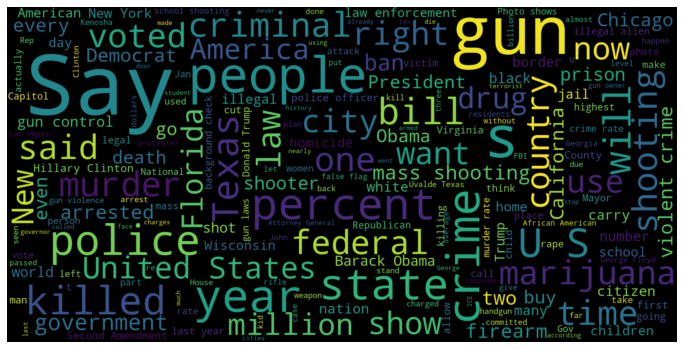

In [ ]:
from wordcloud import WordCloud
from PIL import Image

#Most Frequent words associated with false label 

false_news_words = data[data.Label == 0]
false_news = []
for t in false_news_words.Statement:
    false_news.append(t)
false_news = pd.Series(false_news).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(false_news)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

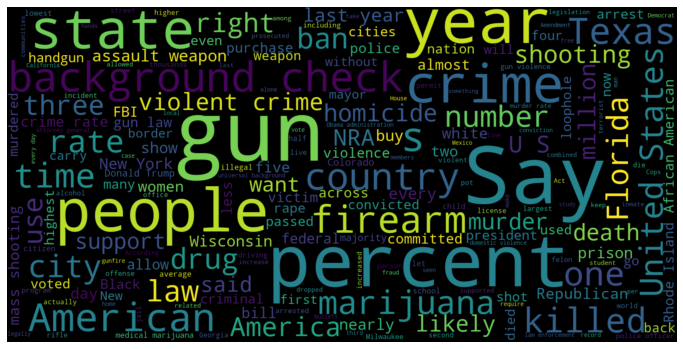

In [ ]:
#Most Frequent words associated with true label 
true_news_words = data[data.Label == 1]
true_news = []
for t in true_news_words.Statement:
    true_news.append(t)
true_news = pd.Series(true_news).str.cat(sep=' ')


wordcloud_true = WordCloud(width=1600, height=800,max_font_size=200).generate(true_news)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
print('The Average time required over the years to fact check the information :',round(data['days_difference'].loc[(data['days_difference']>=0)].mean(),2))

The Average time required over the years to fact check the information : 17.4


In [ ]:
print('The Average time required over the years to check if the statement is true :',round(data['days_difference'].loc[(data['Label']==1) & (data['days_difference']>=0)].mean(),2))

The Average time required over the years to check if the statement is true : 16.71


In [ ]:
print('The Average time required over the years to check if the statement is false :',round(data['days_difference'].loc[(data['Label']==0) & (data['days_difference']>=0)].mean(),2))

The Average time required over the years to check if the statement is false : 17.99


# **Natural Language Processing(part1):**


To convert the text data into a data that can be used by machine learning algorithms we use Scikit-learn library’s inbuilt NLP modules. The below are the actions are taken in this phase.
1.	Remove any alphanumeric and numeric characters from the text.

2.	We are creating variable model_training_dataset to store the information about the MsgContent and model_testing to store the labels.


3.	Splitting the data into training and test datasets.

4.	Using CountVectorizer() to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.


5.	We use TfidfTransformer()to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.


In [ ]:
#clenaing the MsgContent and removing the stop words from the MsgContent 
def remove_symbols(content):
    return re.sub("[^a-zA-Z. ]","",content)

#model_training_dataset=data['Statement']
data['MsgContent'] = data['MsgContent'].apply(remove_symbols)
model_training_dataset=data['MsgContent']
model_testing=data['Label']

nltk.download('stopwords') 
stop_word_removal = stopwords.words('english') 

#splitting the dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(model_training_dataset, model_testing, test_size=0.30, random_state=42)


#using countvectorizer and Tfidf to transfrom the data into machine readable format
vectorizer = text.CountVectorizer(stop_words=stop_word_removal).fit(model_training_dataset)
TfidF = text.TfidfTransformer()
train_X = TfidF.fit_transform(vectorizer.transform(X_train))
Xt = TfidF.transform(vectorizer.transform(X_test))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_test[991]

'may be the city too busy to hate . but for crime  we make time . the city th of in whats widely as the annual  most dangerous  list . st . is no . . last year  was th . so while we still rate among high  crime such as and  were than we used to be . or are we  in of crime  is really getting better  and was it that bad to begin with  we at the same data used by the crime . these predate high  profile in the  highland neighborhood and elsewhere in recent . violent to or uncovered by police from about percent between and . property crime fell by about percent . crime is dropping nationally  too  but more slowly  the data said . the problem is this  the against . doing so to  simplistic and  or incomplete analyses that often create misleading adversely affecting and their  its . press list been at the center of the controversy . until recent  morgan press  a small  kan . publisher  the along with a thick book of crime statistics . the publisher it the  most dangerous  list . although there

# **Machine learning models:**

# Multinomial Naive Bayes Classifier:

Model: 
Naive Bayes Classier is based on Bayes’ theorem, where the adjective Naïve says that features in the dataset are mutually independent. Occurrence of one feature does not affect the probability of occurrence of the other feature. Multinomial Naïve Bayes consider a feature vector where a given term represents the number of times it appears or very often i.e. frequency

1. We initialize the model with default parameters.
2.This is our baseline model.
3.We test the model on the test dataset to evaluate the model
3.we plot the ROC curve to get insights about the model performance

# Support Vector Machine Classifier (with grid search):

Model: Support Vector Machine (SVM) is a supervised machine learning algorithm used for both classification and regression. The objective of SVM algorithm is to find a hyperplane in an N-dimensional space that distinctly classifies the data points. 

GridSearchCV is the process of performing hyperparameter tuning to determine the optimal values for a given model

1. we define a dictionary with hyperparameters as 'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']
2. the support vector classifier along with the hyperparameters dictionary are passed to the grid search model so that best hyperparameters are selected and fitted to the model.
3.We test the model on the test dataset to evaluate the model
4. we plot the ROC curve to get insights about the model performance

# Logistic Regression:

Model: Logistic regression aims to solve classification problems. It does this by predicting categorical outcomes.   Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval, or ratio-level independent variables.

1. We initialize the model with default parameters
2.We test the model on the test dataset to evaluate the model
3.we plot the ROC curve to get insights about the model performance

# XGBoost(with grid search)

Model: XGBoost is involved in reducing the loss function by using weak learners. Decision trees allude to pick the best-divided focuses in light of Gini Impurity and so forth or to limit the loss function. 

1. we define a dictionary with hyperparameters as {"subsample":[0.5, 0.75, 1],"learning_rate":[0.3, 0.1, 0.03],"n_estimators":[100,128,150]}
2. the XGBoost classifier along with the hyperparameters dictionary are passed to the grid search model with 3-fold cross validation so that best hyperparameters are selected and fitted to the model.
3.We test the model on the test dataset to evaluate the model
4. we plot the ROC curve to get insights about the model performance




In [ ]:
#multinomial naive bayes classifier 
NB_model=MultinomialNB()
NB_model.fit(train_X, y_train)

y_pred = NB_model.predict(Xt)

print("Achieved accuracy of Naive Bayes Classifier: %0.3f" %accuracy_score(y_test, y_pred))

Achieved accuracy of Naive Bayes Classifier: 0.669


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


MNB_accy=accuracy_score(y_test, y_pred)
MNB_Recall=recall_score(y_test, y_pred,average='micro')
MNB_Precision=precision_score(y_test, y_pred,average='micro')
MNB_f1=f1_score(y_test, y_pred,average='micro')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71       288
           1       0.75      0.52      0.61       292

    accuracy                           0.67       580
   macro avg       0.69      0.67      0.66       580
weighted avg       0.69      0.67      0.66       580



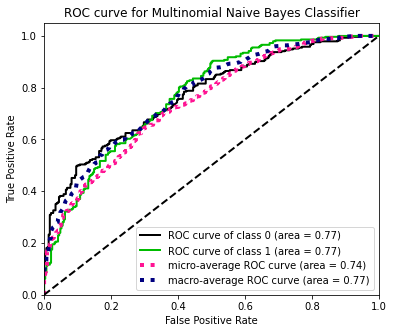

In [ ]:
#visualizing the ROC curves for naive bayes classifier
y_probas = NB_model.predict_proba(Xt)
skplt.metrics.plot_roc(y_test, y_probas,figsize=(6,5))
plt.title('ROC curve for Multinomial Naive Bayes Classifier')
plt.show()

In [ ]:
#using grid search cv with support vector machine classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_grid = GridSearchCV(SVC(), param_grid)
svm_grid.fit(train_X, y_train)
print(svm_grid.best_estimator_)
y_pred_svc = svm_grid.predict(Xt)
print("Achieved accuracy: %0.3f" % accuracy_score(y_test, y_pred_svc))



SVC(C=10, gamma=0.1)
Achieved accuracy: 0.734


In [ ]:
from sklearn.metrics import roc_curve, auc

SVM_accy=accuracy_score(y_test, y_pred_svc)
SVM_Recall=recall_score(y_test, y_pred_svc,average='micro')
SVM_Precision=precision_score(y_test, y_pred_svc,average='micro')
SVM_f1=f1_score(y_test, y_pred_svc,average='micro')


print(classification_report(y_test, y_pred_svc))


              precision    recall  f1-score   support

           0       0.71      0.79      0.75       288
           1       0.77      0.68      0.72       292

    accuracy                           0.73       580
   macro avg       0.74      0.73      0.73       580
weighted avg       0.74      0.73      0.73       580



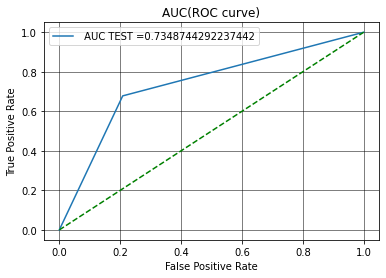

In [ ]:
#visualizing the ROC curves for support vector classifier
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_svc)


plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

Achieved accuracy: 0.709
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       288
           1       0.76      0.61      0.68       292

    accuracy                           0.71       580
   macro avg       0.72      0.71      0.71       580
weighted avg       0.72      0.71      0.71       580



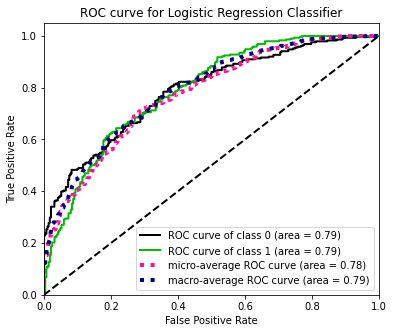

In [ ]:
#Logistic regression model
from sklearn.linear_model import LogisticRegression
Logistic_reg_model=LogisticRegression(solver='lbfgs',max_iter=10000)
Logistic_reg_model.fit(train_X, y_train)
log_y_pred = Logistic_reg_model.predict(Xt)
print("Achieved accuracy: %0.3f" %
      accuracy_score(y_test, log_y_pred))
print(classification_report(y_test, log_y_pred))

#visualizing the ROC curves for logistic regression classifier
y_probas_log = Logistic_reg_model.predict_proba(Xt)
skplt.metrics.plot_roc(y_test, y_probas_log,figsize=(6,5))
plt.title('ROC curve for Logistic Regression Classifier')
plt.show()

In [ ]:
log_accy=accuracy_score(y_test, log_y_pred)
log_Recall=recall_score(y_test, log_y_pred,average='micro')
log_Precision=precision_score(y_test, log_y_pred,average='micro')
log_f1=f1_score(y_test, log_y_pred,average='micro')

XGBClassifier(learning_rate=0.3, n_estimators=150, n_jobs=-1, subsample=0.75)
0.8172413793103448
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       288
           1       0.85      0.78      0.81       292

    accuracy                           0.82       580
   macro avg       0.82      0.82      0.82       580
weighted avg       0.82      0.82      0.82       580



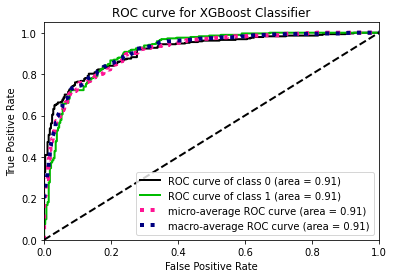

In [ ]:
#using grid search cv with XGBoost classifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

Param = {"subsample":[0.5, 0.75, 1],
              "learning_rate":[0.3, 0.1, 0.03],
               "n_estimators":[100,128,150]}

model = XGBClassifier(n_estimators=100, n_jobs=-1)

model_gs = GridSearchCV(model,param_grid=Param,cv=3,scoring="accuracy")

model_gs.fit(train_X, y_train)
boost_pred=model_gs.predict(Xt)
print(model_gs.best_estimator_)
print(model_gs.score(Xt, y_test))
print(classification_report(y_test,boost_pred))

#visualizing the ROC curves for XGBoost classifier
bosst_probab_pred=model_gs.predict_proba(Xt)
skplt.metrics.plot_roc(y_test, bosst_probab_pred)
plt.title('ROC curve for XGBoost Classifier')
plt.show()

In [ ]:

xboost_accy=accuracy_score(y_test, boost_pred)
xboost_Recall=recall_score(y_test, boost_pred,average='micro')
xboost_Precision=precision_score(y_test, boost_pred,average='micro')
xboost_f1=f1_score(y_test, boost_pred,average='micro')



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout,SimpleRNN
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name() 

''

# **Natural Language Processing (part2):**


When it comes to text preprocessing for neural networks, we make use of the in-built NLP modules of the Tensorflow library to convert the text into machine readable formats. We are following the below steps for text pre processing for neural networks:
1.	We create two variables X and y that store the content and the target variables and split the dataset into training and test datasets.

2.	we use the Tokenizer() from TensorFlow to split the texts into tokens(words) while keeping only the most occurring words in the text corpus. The num_words parameter keeps a prespecified number(in this case 5000 words) of words in the text only.

3.	We  then pad the sentences using pad_sequences() function as the model expects that each sequence(each training example) will be of the same length(same number of words/tokens).

4.	We convert the labels to categorical values (one hot vector encoding)


In [ ]:
#using tokenizer from tensorflow to tokenize the MsgContent column
X = data['MsgContent']
y = data['Label']

X1_train, X_test, y_train, y_test=  train_test_split(X,y, test_size=0.25, random_state=42) 

maxlen = 500
max_features = 5000
oov_tok = '<OOV>'

from keras.preprocessing.text import Tokenizer
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,oov_token=oov_tok)
tokenizer.fit_on_texts(X1_train.tolist())
train_X = tokenizer.texts_to_sequences(X1_train.tolist())
test_X = tokenizer.texts_to_sequences(X_test.tolist())

word_index = tokenizer.word_index

In [ ]:
#padding the sequences so that they are of the same length
trunc_type = 'post'
padding_type = 'post' 
vocab_size=len(word_index)+1

train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=maxlen,padding=padding_type, truncating=trunc_type)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=maxlen,padding=padding_type, truncating=trunc_type)

vocab_len = len(word_index)+1
emb_dim = 100
#converting the test lables into categorigial(one hot encoding of the lables)
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np
train_labels = to_categorical(np.asarray(y_train))
test_labels = to_categorical(np.array(y_test))



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential


# **Deep Learning Models:**

**Bi-Directional LSTM**

Model: A bidirectional LSTM, often known as a biLSTM, is a sequence processing model that consists of two LSTMs one working in a forward direction, and the other in the reverse direction. Because of this, biLSTMs enable additional training by passing the text sequence twice.

Our model consists of the below:

1st Layer — Embedding layer: Applies the embedding of the given size to the input sequence

2nd Layer — Bi-Directional LSTM Layer: Contains a LSTM with 16 neurons with a dropout rate of 0.4

3rd Layer — GlobalMaxPooling1D layer : down samples the input representation by taking the maximum value over the time dimension

4th Layer:  Dense Layer: Connects all the outputs from previous layers to its neurons

Activation Function — Sigmoid Activation Function: This will give us the outputs in the values of 0 and 1

Loss Function — Binary Cross Entropy: Predicts the class output between 0 and 1

We use the 70 and 30 split for training and validating the model and use test data to evaluate the model


**GRU:**

Model:  GRUs are improved version of standard recurrent neural network.  GRU uses update gate and reset gate which decide what information should be passed to the output because of this they can be trained to keep information for a long time.

Our model consists of the below:

1st Layer — Embedding layer: Applies the embedding of the given size to the input sequence

2nd Layer — GRU Layer: Contains a GRU with 100 neurons with a dropout rate of 0.2

3rd Layer:  Dense Layer: Connects all the outputs from previous layers to its neurons

Activation Function — Sigmoid Activation Function: This will give us the outputs in the values of 0 and 1

Loss Function — Binary Cross Entropy: Predicts the class output between 0 and 1

We use the 70 and 30 split for training and validating the model and use test data to evaluate the model


In [ ]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding 
from sklearn.metrics import precision_recall_fscore_support as score

#building the Bi-LSTM model
embedding_dim = 100  
# Model Training
BILSTM_model = Sequential()
BILSTM_model.add(Embedding(vocab_size, 
                   embedding_dim,
                   input_length=maxlen))
# Bidirectional LSTM 
BILSTM_model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   
BILSTM_model.add(GlobalMaxPool1D())
BILSTM_model.add(Dense(2,activation='sigmoid'))  
BILSTM_model.summary()
BILSTM_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1158900   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 32)          14976     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1,173,942
Trainable params: 1,173,942
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 256
epochs  = 30
bi_mod = BILSTM_model.fit(train_X, train_labels,validation_split=0.3,batch_size = batch_size, epochs = epochs)

Epoch 1/30
4/4 [==============================] - 13s 2s/step - loss: 0.6876 - accuracy: 0.5533 - val_loss: 0.6914 - val_accuracy: 0.5149
Epoch 2/30
4/4 [==============================] - 7s 2s/step - loss: 0.6847 - accuracy: 0.5533 - val_loss: 0.6908 - val_accuracy: 0.5149
Epoch 3/30
4/4 [==============================] - 6s 2s/step - loss: 0.6818 - accuracy: 0.5533 - val_loss: 0.6899 - val_accuracy: 0.5149
Epoch 4/30
4/4 [==============================] - 7s 2s/step - loss: 0.6782 - accuracy: 0.5533 - val_loss: 0.6888 - val_accuracy: 0.5149
Epoch 5/30
4/4 [==============================] - 6s 2s/step - loss: 0.6739 - accuracy: 0.5533 - val_loss: 0.6870 - val_accuracy: 0.5149
Epoch 6/30
4/4 [==============================] - 6s 2s/step - loss: 0.6704 - accuracy: 0.5533 - val_loss: 0.6849 - val_accuracy: 0.5149
Epoch 7/30
4/4 [==============================] - 7s 2s/step - loss: 0.6652 - accuracy: 0.5533 - val_loss: 0.6822 - val_accuracy: 0.5149
Epoch 8/30
4/4 [========================

In [ ]:
bilstm_prediction = BILSTM_model.predict(test_X)
#predicted_bi_lstm
precision, recall, fscore, support = score(test_labels, bilstm_prediction.round())
print(classification_report(test_labels, bilstm_prediction.round()))

16/16 [==============================] - 2s 66ms/step
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       242
           1       0.67      0.55      0.60       242

   micro avg       0.64      0.64      0.64       484
   macro avg       0.64      0.64      0.64       484
weighted avg       0.64      0.64      0.64       484
 samples avg       0.64      0.64      0.64       484



In [ ]:
bilstm_accy=accuracy_score(test_labels, bilstm_prediction.round())
bilstm_Recall=recall_score(test_labels, bilstm_prediction.round(),average='micro')
bilstm_Precision=precision_score(test_labels, bilstm_prediction.round(),average='micro')
bilstm_f1=f1_score(test_labels, bilstm_prediction.round(),average='micro')

In [ ]:
#Building the GRU model
GRUmodel = Sequential()
GRUmodel.add(Embedding(vocab_size, emb_dim, input_length=maxlen))
GRUmodel.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
#lstm_model.add(Dropout(0.2))
GRUmodel.add(Dense(2, activation = 'sigmoid'))
GRUmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(GRUmodel.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          1158900   
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,219,702
Trainable params: 1,219,702
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 256
epochs  = 30
bi_mod = GRUmodel.fit(train_X, train_labels,validation_split=0.3,batch_size = batch_size, epochs = epochs)

Epoch 1/30
4/4 [==============================] - 20s 4s/step - loss: 0.6901 - accuracy: 0.5582 - val_loss: 0.6907 - val_accuracy: 0.5149
Epoch 2/30
4/4 [==============================] - 16s 4s/step - loss: 0.6820 - accuracy: 0.5542 - val_loss: 0.6897 - val_accuracy: 0.5149
Epoch 3/30
4/4 [==============================] - 16s 4s/step - loss: 0.6738 - accuracy: 0.5533 - val_loss: 0.6917 - val_accuracy: 0.5149
Epoch 4/30
4/4 [==============================] - 16s 4s/step - loss: 0.6649 - accuracy: 0.5533 - val_loss: 0.6974 - val_accuracy: 0.5172
Epoch 5/30
4/4 [==============================] - 16s 4s/step - loss: 0.6549 - accuracy: 0.5759 - val_loss: 0.6932 - val_accuracy: 0.5356
Epoch 6/30
4/4 [==============================] - 16s 4s/step - loss: 0.6407 - accuracy: 0.6963 - val_loss: 0.6901 - val_accuracy: 0.5724
Epoch 7/30
4/4 [==============================] - 16s 4s/step - loss: 0.6230 - accuracy: 0.7968 - val_loss: 0.6856 - val_accuracy: 0.6000
Epoch 8/30
4/4 [==================

In [ ]:
GRU_prediction = GRUmodel.predict(test_X)
#predicted_bi_lstm
precision, recall, fscore, support = score(test_labels, GRU_prediction.round())
print(classification_report(test_labels, GRU_prediction.round()))

16/16 [==============================] - 2s 122ms/step
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       242
           1       0.69      0.56      0.62       242

   micro avg       0.65      0.65      0.65       484
   macro avg       0.65      0.65      0.65       484
weighted avg       0.65      0.65      0.65       484
 samples avg       0.65      0.65      0.65       484



In [ ]:
gru_accy=accuracy_score(test_labels, GRU_prediction.round())
gru_Recall=recall_score(test_labels, GRU_prediction.round(),average='micro')
gru_Precision=precision_score(test_labels, GRU_prediction.round(),average='micro')
gru_f1=f1_score(test_labels, GRU_prediction.round(),average='micro')

# **Model Evaluation:**

We use the below metrics to evaluate our models:

# Accuracy:
 Accuracy score in machine learning is an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made. We calculate it by dividing the number of correct predictions by the total number of predictions.

# Precision: 
Percentage of correct predictions of a class among all predictions for that class.

# Recall: 
Proportion of correct predictions of a class and the total number of occurrences of that class.

# Confusion matrix: 
A tabular summary of True/False Positive/Negative prediction rates.

# ROC curve: 
A binary classification diagnostic plot.

After comparing the models on all these metrics we can conclude that the XGBoost classifier with gridsearch CV performs the best and we use this as a final model.


In [ ]:
#tabulating the results
from prettytable import PrettyTable
myTable = PrettyTable(["Model", "Accuracy", "Precision", "Recall","F1"])
myTable.add_row(["Naive bayes Classifier", round(MNB_accy,2), round(MNB_Precision,2), round(MNB_Recall,2),round(MNB_f1,2)])
myTable.add_row(["SVM Support Vector Classifier with grid search",round(SVM_accy,2),round(SVM_Precision,2),round(SVM_Recall,2),round(SVM_f1,2)])
myTable.add_row(["logistic regression ",round(log_accy,2),round(log_Precision,2),round(log_Recall,2),round(log_f1,2)])
myTable.add_row(["XGboost with Grid Search ",round(xboost_accy,2),round(xboost_Precision,2),round(xboost_Recall,2),round(xboost_f1,2)])
myTable.add_row(["Bi-LSTM",round(bilstm_accy,2),round(bilstm_Precision,2),round(bilstm_Recall,2),round(bilstm_f1,2)])
myTable.add_row(["GRU",round(gru_accy,2),round(gru_Precision,2),round(gru_Recall,2),round(gru_f1,2)])
print(myTable)

+------------------------------------------------+----------+-----------+--------+------+
|                     Model                      | Accuracy | Precision | Recall |  F1  |
+------------------------------------------------+----------+-----------+--------+------+
|             Naive bayes Classifier             |   0.67   |    0.67   |  0.67  | 0.67 |
| SVM Support Vector Classifier with grid search |   0.73   |    0.73   |  0.73  | 0.73 |
|              logistic regression               |   0.71   |    0.71   |  0.71  | 0.71 |
|           XGboost with Grid Search             |   0.82   |    0.82   |  0.82  | 0.82 |
|                    Bi-LSTM                     |   0.64   |    0.64   |  0.64  | 0.64 |
|                      GRU                       |   0.64   |    0.65   |  0.65  | 0.65 |
+------------------------------------------------+----------+-----------+--------+------+


In [ ]:
import io
quote=str(input('Please Enter the text here : '))


Please Enter the text here : Sen. Amy Klobuchar, D-Minn. said "one in six local election officials have received threats of violence," that threats against judges have doubled over four years and threats against members of Congress have increased by 10 times over five years.A survey done for the Brennan Center earlier this year of about 600 local election officials nationwide found 1 in 6 faced threats. Government data shows that threats against officials who work in federal courthouses including judges, plus against lawmakers, have increased in recent years. We rated this statement


In [ ]:
import csv

import pickle
  

saved_model = pickle.dumps(model_gs)
  
boost_from_pickle = pickle.loads(saved_model)
  
df = pd.read_csv(io.StringIO(quote),names=['text'],encoding='utf-8',quoting=csv.QUOTE_NONE)

df['text'] = df['text'].map(lambda x: cleaner(x))
text_transorm = TfidF.transform(vectorizer.transform(df['text']))
predict_class=boost_from_pickle.predict(text_transorm)
if predict_class==0:
  print('false information')
else:
  print('true information')


false information
